# Data prepare and FC_DNN

In [14]:
# Import data_prepare modul that contains functions that we created.
from data_prepare import *
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from scripts.reconstruction_minimal import createAudio
import scipy.io.wavfile as wavfile

# Prepare data for learning

We prepare the data for learning neural networks. We use a function that execute the results of the last milestone get a train-ready dataset.

In [15]:
def generate_datasets(pt, feat_path=r'./features'):
    
    r"""
    Generate train and test datasets from the one sample of the raw data.
    param pt: name of the sample
    param feat_path: path of the raw data file
  """
    
    output = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))
    input = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))
    
    # Reduce Dimensions
    pca = PCA()
    pca.fit(input)
    input = np.dot(input, pca.components_[:50,:].T)

    # Generate train, validation and test datasets
    X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.1)
    
    # Standardize input
    mu_input = np.mean(X_train, axis=0)
    std_input = np.std(X_train, axis=0)
    X_train = (X_train-mu_input)/std_input
    X_test = (X_test-mu_input)/std_input

    # Standardize output
    mu_output = np.mean(Y_train, axis=0)
    std_output = np.std(Y_train, axis=0)
    Y_train = (Y_train-mu_output)/std_output
    Y_test = (Y_test-mu_output)/std_output


    return (X_train, X_test, Y_train, Y_test, mu_output, std_output)

In [50]:
def generate_merged_dataset():
    test_dict = {}
    pts = ['sub-%02d'%i for i in range(1,11)]
    (X_train, X_test, Y_train, Y_test, mu_output, std_output) = generate_datasets(pts[0])
    test_dict[str(0)] = {'X':X_test, 'Y':Y_test, 'mu':mu_output, 'std':std_output}
    for i, pt in enumerate(pts[1:]):
        (XN_train, XN_test, YN_train, YN_test, N_mu_output, N_std_output) = generate_datasets(pt)
        X_train = np.concatenate((X_train, XN_train))
        Y_train = np.concatenate((Y_train, YN_train))
        test_dict[str(i+1)] = {'X':X_test, 'Y':Y_test, 'mu':N_mu_output, 'std':N_std_output}
    return (X_train, Y_train, test_dict)

In [51]:
(X_train, Y_train, test_dict) = generate_merged_dataset()

# Create FC-DNN network

In [20]:
def create_fndnn(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(units=60, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=output_dim, activation='linear'))

    optimizer=Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model

In [22]:
epochs = 1000
batch_size = 128

early_stopping=EarlyStopping(patience=5, verbose=1)
checkpointer=ModelCheckpoint(filepath='fcdnn.hdf5', save_best_only=True, verbose=1)

model = create_fndnn(input_dim=X_train.shape[1], output_dim=Y_train.shape[1])

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, early_stopping])

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.92224, saving model to fcdnn.hdf5
1888/1888 - 6s - loss: 1.0087 - mae: 0.7748 - val_loss: 0.9222 - val_mae: 0.6141 - 6s/epoch - 3ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.92224 to 0.90409, saving model to fcdnn.hdf5
1888/1888 - 5s - loss: 0.9482 - mae: 0.7415 - val_loss: 0.9041 - val_mae: 0.6092 - 5s/epoch - 3ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.90409 to 0.88875, saving model to fcdnn.hdf5
1888/1888 - 5s - loss: 0.9259 - mae: 0.7280 - val_loss: 0.8887 - val_mae: 0.6024 - 5s/epoch - 3ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 0.88875
1888/1888 - 5s - loss: 0.9098 - mae: 0.7178 - val_loss: 0.9002 - val_mae: 0.6067 - 5s/epoch - 3ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 0.88875
1888/1888 - 5s - loss: 0.9001 - mae: 0.7120 - val_loss: 0.9014 - val_mae: 0.5953 - 5s/epoch - 3ms/step
Epoch 6/1000

Epoch 6: val_loss did not improve from 0.88875
1888/1888 - 5s - loss: 0.89

In [57]:
def test_model(model, test_dict):
    preds = []
    spectograms = []
    losses = []
    for i in range(10):
        y_pred = model.predict(test_dict[str(i)]['X'])
        losses.append(mean_absolute_error(test_dict[str(i)]['Y'], y_pred))
        preds.append(y_pred * test_dict[str(i)]['std'] + test_dict[str(i)]['mu'])
        spectograms.append(test_dict[str(i)]['Y'] * test_dict[str(i)]['std'] + test_dict[str(i)]['mu'])
    mae = np.sum(losses)
    print('Mean absolute error of test set:{mae}')
    return preds, spectograms

In [54]:
# Viz spectrograms
def visualize_results(preds, spectograms):

    cm='viridis'
    fig, ax = plt.subplots(2, sharex=True)

    for i in range(10):
        #Plot spectrograms
        ax[0].imshow(np.flipud(spectograms[i].T), cmap=cm, interpolation=None,aspect='auto')
        ax[0].set_ylabel('Log Mel-Spec Bin')
        ax[1].imshow(np.flipud(preds[i].T), cmap=cm, interpolation=None,aspect='auto')
        ax[1].set_ylabel('Log Mel-Spec Bin')

In [60]:
# Synthesize audio files
def synthesize_audio(preds, spectograms):
    result_path = 'dnn_results'
    winLength = 0.05
    frameshift = 0.01
    audiosr = 16000
    if not os.path.isdir(result_path):
        os.makedirs(result_path)
    for i in range(10):
        #Synthesize waveform from spectrogram using Griffin-Lim
        reconstructedWav = createAudio(preds[i],audiosr=audiosr,winLength=winLength,frameshift=frameshift)
        wavfile.write(os.path.join(result_path,f'{i+1}_predicted.wav'),int(audiosr),reconstructedWav)

        #For comparison synthesize the original spectrogram with Griffin-Lim
        origWav = createAudio(spectograms[i],audiosr=audiosr,winLength=winLength,frameshift=frameshift)
        wavfile.write(os.path.join(result_path,f'{i+1}_orig_synthesized.wav'),int(audiosr),origWav)

In [ ]:
preds, spectograms = test_model(model=model, test_dict=test_dict)

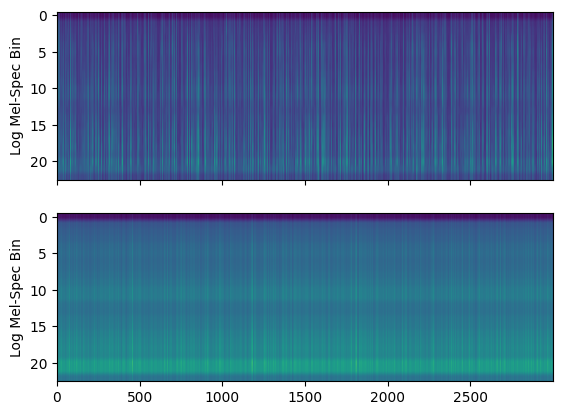

In [61]:
visualize_results(preds=preds, spectograms=spectograms)
synthesize_audio(preds=preds, spectograms=spectograms)